In [216]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [217]:
def calculate_DR_RollingStd(ticker, startDate, endDate, rolling_window):
    """
    Calculate the rolling volatility of a given stock ticker and return the DataFrame with the ticker included.

    Parameters:
    ticker (str): The stock ticker symbol (e.g., "SPY").
    startDate (str): The start date for downloading data (format: "YYYY-MM-DD").
    endDate (str): The end date for downloading data (format: "YYYY-MM-DD").
    rolling_window (int): The window size for calculating rolling volatility.

    Returns:
    pandas.DataFrame: The DataFrame containing the rolling volatility.
    """
    # Download stock data
    df = yf.download(ticker, start=startDate, end=endDate)
    
    # Calculate daily percentage change
    df["dailyReturns"] = df["Adj Close"].pct_change()
    
    # Calculate rolling volatility
    df["rolling"] = df["dailyReturns"].rolling(window=rolling_window).std()
    
    # Return the DataFrame with the ticker column
    return df


In [218]:
# Initial end date as a string
endDate = "2024-08-22"

# Convert the endDate string to a datetime object
end_date_obj = pd.to_datetime(endDate)

# Subtract x days from the end date
start_date_obj = end_date_obj - pd.tseries.offsets.BDay(90)

# Convert the start date back to a string if needed
startDate = start_date_obj.strftime("%Y-%m-%d")

print("Start Date:", startDate)
print("End Date:", endDate)

rolling_window = 5

dfSPY = calculate_DR_RollingStd("SPY", startDate, endDate, rolling_window)
dfNote3Y = calculate_DR_RollingStd("Z3N=F", startDate, endDate, rolling_window)
dfGLD = calculate_DR_RollingStd("GLD", startDate, endDate, rolling_window)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Start Date: 2024-04-18
End Date: 2024-08-22


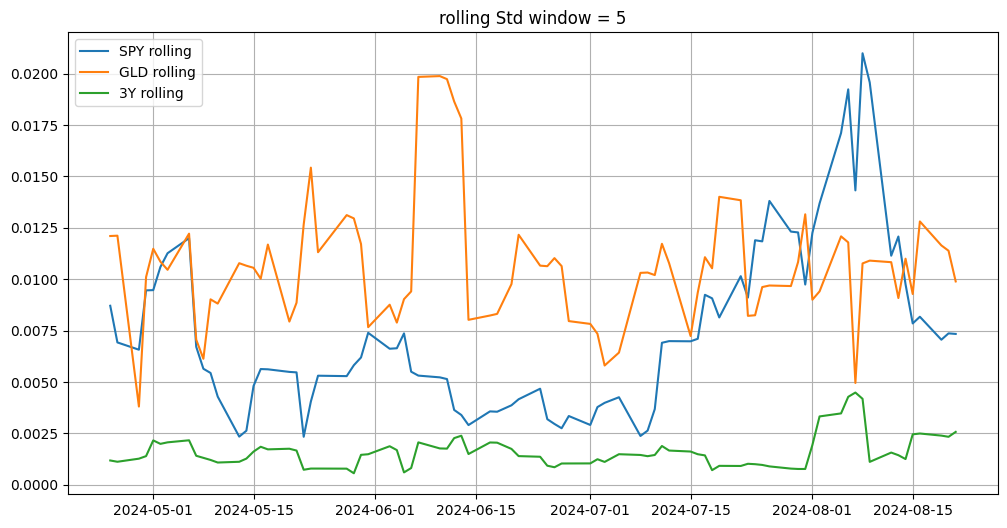

In [219]:
plt.figure(figsize=(12,6))
plt.plot(dfSPY["rolling"], label="SPY rolling")
plt.plot(dfGLD["rolling"], label="GLD rolling")
plt.plot(dfNote3Y["rolling"], label="3Y rolling")
plt.legend()
plt.grid(True)
plt.title(label='rolling Std window = '+str(rolling_window))
plt.show()

In [220]:
spy = dfSPY["rolling"].iloc[-1]
note = dfNote3Y["rolling"].iloc[-1]
gold = dfGLD["rolling"].iloc[-1]
# print(spy)
# print(note)
# print(gold)

total = (1/spy)+(1/note)+(1/gold)

weight_SPY = (1/spy)/total
weight_note = (1/note)/total
weight_gold = (1/gold)/total

print(round(weight_SPY,4), round(weight_note,4), round(weight_gold,4))

# as of 5 Aug 2024 post rebalancing
SPY, UST, GLD = 2.6, 9.08, 3.87
total = SPY+UST+GLD
curr_SPY = SPY/total
curr_UST = UST/total
curr_GLD = GLD/total

print(round(curr_SPY,4), round(curr_UST,4), round(curr_GLD,4))

0.2179 0.6204 0.1617
0.1672 0.5839 0.2489


In [221]:
combined_df = pd.concat([dfSPY['rolling'], dfNote3Y['rolling'], dfGLD['rolling']], axis=1)
combined_df.columns = ['SPY_Rolling', 'Note3Y_Rolling', 'GLD_Rolling']
combined_df = combined_df.dropna()

combined_df_dailyChange = pd.concat([dfSPY['dailyReturns'], dfNote3Y['dailyReturns'], dfGLD['dailyReturns']], axis=1)
combined_df_dailyChange.columns = ['SPY_DailyReturns', 'Note3Y_DailyReturns', 'GLD_DailyReturns']
combined_df_dailyChange = combined_df_dailyChange.dropna()

# print(combined_df)
# print(combined_df_dailyChange)

                 SPY_Rolling  Note3Y_Rolling   GLD_Rolling
SPY_Rolling     1.710357e-05    1.487426e-06 -6.263107e-07
Note3Y_Rolling  1.487426e-06    6.246309e-07  8.241519e-08
GLD_Rolling    -6.263107e-07    8.241519e-08  9.065370e-06



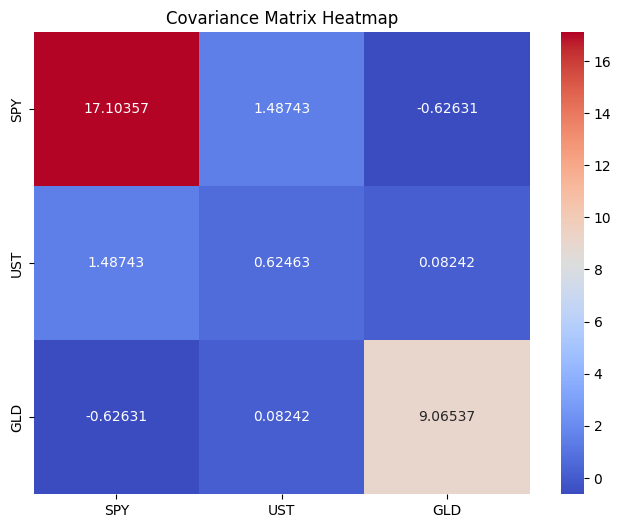

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the covariance matrix of asset returns
print(combined_df.cov())
print()
cov_matrix = combined_df.cov().values

assets = ['SPY', 'UST', 'GLD']  # Replace with your actual asset names
cov_df = pd.DataFrame(cov_matrix, index=assets, columns=assets)

# Plot the covariance matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cov_df*1e6, annot=True, cmap='coolwarm', fmt=".5f")
plt.title('Covariance Matrix Heatmap')
plt.show()

                SPY_Rolling  Note3Y_Rolling  GLD_Rolling
SPY_Rolling        1.000000        0.455072    -0.050298
Note3Y_Rolling     0.455072        1.000000     0.034634
GLD_Rolling       -0.050298        0.034634     1.000000


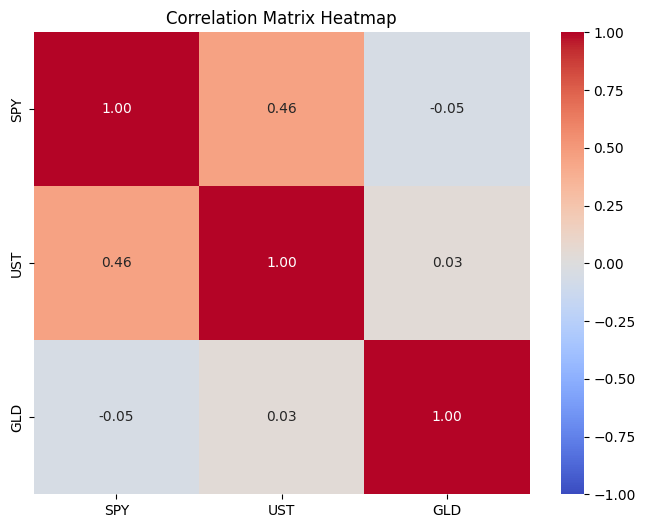

In [223]:
# Calculate the correlation matrix of asset returns
correlation_matrix = combined_df.corr().values
print(combined_df.corr())

# Create a DataFrame for better labels
assets = ['SPY', 'UST', 'GLD']  # Replace with your actual asset names
corr_df = pd.DataFrame(correlation_matrix, index=assets, columns=assets)

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

[[ 1.71035693e-05  6.76886269e-07 -3.15023938e-08]
 [ 6.76886269e-07  6.24630939e-07  2.85436809e-09]
 [-3.15023938e-08  2.85436809e-09  9.06536968e-06]]


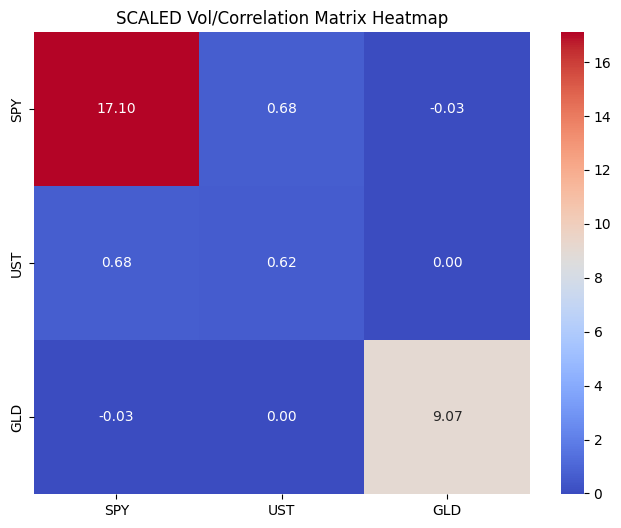

In [224]:
# The covariance matrix combines both the volatility and correlation data:
cov_matrix = cov_matrix * abs(correlation_matrix)
print(cov_matrix)

# Create a DataFrame for better labels
assets = ['SPY', 'UST', 'GLD']  # Replace with your actual asset names
cov_df = pd.DataFrame(cov_matrix*1e6, index=assets, columns=assets)

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cov_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('SCALED Vol/Correlation Matrix Heatmap')
plt.show()

In [225]:
# Assume weights is a numpy array of current portfolio weights
weights = np.array([curr_SPY, curr_UST, curr_GLD]) 

# Calculate the portfolio volatility
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
annulised_vol = portfolio_volatility * np.sqrt(252)
print("daily vol (beta) = {:.5f}".format(portfolio_volatility))
print("annualised vol (beta) = {:.5f}".format(annulised_vol))
print()

# Calculate the Marginal Contribution to Risk for each asset
MCR = np.dot(cov_matrix, weights) / portfolio_volatility

# Contribution of each asset to the total portfolio risk
risk_contributions = weights * MCR

# Display the results
mcr_df = pd.DataFrame({
    'Asset': combined_df.columns,
    'Weight': weights,
    'MCR': MCR,
    'Risk Contribution': risk_contributions
})

print(mcr_df)

daily vol (beta) = 0.00118
annualised vol (beta) = 0.01867

            Asset    Weight       MCR  Risk Contribution
0     SPY_Rolling  0.167203  0.002761           0.000462
1  Note3Y_Rolling  0.583923  0.000407           0.000238
2     GLD_Rolling  0.248875  0.001915           0.000477


In [226]:
def portfolio_volatility(weights, cov_matrix):
    """Calculate the portfolio volatility."""
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def risk_contribution(weights, cov_matrix):
    """Calculate the risk contributions of each asset."""
    portfolio_vol = portfolio_volatility(weights, cov_matrix)
    marginal_contrib = np.dot(cov_matrix, weights) / portfolio_vol
    return weights * marginal_contrib

def risk_parity_objective(weights, cov_matrix):
    """Objective function to minimize the variance of risk contributions."""
    n = len(weights)
    portfolio_vol = portfolio_volatility(weights, cov_matrix)
    target_risk_contrib = portfolio_vol / n
    risk_contrib = risk_contribution(weights, cov_matrix)
    return np.sum((risk_contrib - target_risk_contrib) ** 2) # This line returns the sum of the squared differences between the actual risk contributions and the target risk contribution for each asset.

In [227]:
from scipy.optimize import minimize

# Scale the covariance matrix
scaling_factor = 1e6  # You can experiment with different scaling factors
scaled_cov_matrix = cov_matrix * scaling_factor

print("Initial Cov Matrix:", cov_matrix)
print()
print("Scaled Cov Matrix:", scaled_cov_matrix)
print()

# Initial guess for the weights
initial_guess = weights

# Constraints: Sum of weights = 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for weights: between 0 and 1
bounds = tuple((0, 1) for _ in range(len(initial_guess)))

# Minimize the risk parity objective function
result = minimize(
    risk_parity_objective, 
    initial_guess, 
    args=(scaled_cov_matrix,), 
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints,
    options={'ftol': 1e-9, 'disp': True}  # Adjusted options
)

# Check if optimization was successful
if result.success:
    optimal_weights = result.x
    print("Optimal Weights:", optimal_weights)
else:
    print("Optimization failed:", result.message)

print()    
    
print("Initial Risk Contributions (not scaled):", risk_contribution(initial_guess, cov_matrix))
print("Optimized Risk Contributions (scaled):", risk_contribution(result.x, scaled_cov_matrix))
print()

# Display the results
res = pd.DataFrame({
    'Asset': ["SPY", "3y UST", "GLD"],
    'Weight (%)': initial_guess,
    'Weight (USD)': initial_guess*total*1000,
    'Optimal Weights (%)': optimal_weights,
    'Optimal Weights (USD)': optimal_weights*total*1000,
    'To rebalance (%)': optimal_weights-initial_guess,
    'To rebalance (USD)': ((optimal_weights-initial_guess)*total)*1000
})
print(res)

Initial Cov Matrix: [[ 1.71035693e-05  6.76886269e-07 -3.15023938e-08]
 [ 6.76886269e-07  6.24630939e-07  2.85436809e-09]
 [-3.15023938e-08  2.85436809e-09  9.06536968e-06]]

Scaled Cov Matrix: [[ 1.71035693e+01  6.76886269e-01 -3.15023938e-02]
 [ 6.76886269e-01  6.24630939e-01  2.85436809e-03]
 [-3.15023938e-02  2.85436809e-03  9.06536968e+00]]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.460924530874339e-13
            Iterations: 5
            Function evaluations: 23
            Gradient evaluations: 5
Optimal Weights: [0.12936506 0.67554973 0.19508521]

Initial Risk Contributions (not scaled): [0.00046167 0.00023765 0.00047669]
Optimized Risk Contributions (scaled): [0.3389169  0.33891565 0.33891659]

    Asset  Weight (%)  Weight (USD)  Optimal Weights (%)  \
0     SPY    0.167203        2600.0             0.129365   
1  3y UST    0.583923        9080.0             0.675550   
2     GLD    0.248875        3870.0             0.195085